In [18]:
import sys
sys.path.append("C:\\Users\\olgat\\Desktop\\Stage Amiens\\6_Github") 
import functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import IPython
import IPython.display
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, LSTM
from keras.models import Sequential

In [2]:
# Face area markers
def list_to_array(input_list):
    np_list=[]
    for elem in input_list:
        df = pd.read_csv(elem, header=None).fillna(0)
        df = df.iloc[:,[38, 40, 41,	42,	88,	89,	90,	91,	92,	83,	84,	85,	86,	87,	74,	75,	76,	77,	78,	79,	80,	81,	82,	72,	73,	67, # LEFT
                        98,	45,	44,	43,	46,	47,	48,	49,	50,	51,	52,	53,	54,	55,	56,	57,	58,	59,	60,	61,	62,	63,	64,	68,	69,	65]]

        np_array = df.to_numpy()
        np_list.append(np.nan_to_num(np_array))
    return np_list

In [3]:
path = "C:/Users/olgat/Desktop/Stage Amiens/4 - ML_MoCap/Mvt5/5MhrdP0_M5"
dP0_csv = functions.list_of_files(path)
dP0_csv

['C:\\Users\\olgat\\Desktop\\Stage Amiens\\4 - ML_MoCap\\Mvt5\\5MhrdP0_M5\\MM01_M5.csv',
 'C:\\Users\\olgat\\Desktop\\Stage Amiens\\4 - ML_MoCap\\Mvt5\\5MhrdP0_M5\\QS_M5.csv',
 'C:\\Users\\olgat\\Desktop\\Stage Amiens\\4 - ML_MoCap\\Mvt5\\5MhrdP0_M5\\AG01_M5.csv',
 'C:\\Users\\olgat\\Desktop\\Stage Amiens\\4 - ML_MoCap\\Mvt5\\5MhrdP0_M5\\M5.csv',
 'C:\\Users\\olgat\\Desktop\\Stage Amiens\\4 - ML_MoCap\\Mvt5\\5MhrdP0_M5\\RL01_M5.csv',
 'C:\\Users\\olgat\\Desktop\\Stage Amiens\\4 - ML_MoCap\\Mvt5\\5MhrdP0_M5\\1_AC_M5.csv',
 'C:\\Users\\olgat\\Desktop\\Stage Amiens\\4 - ML_MoCap\\Mvt5\\5MhrdP0_M5\\3_CN01_M5.csv',
 'C:\\Users\\olgat\\Desktop\\Stage Amiens\\4 - ML_MoCap\\Mvt5\\5MhrdP0_M5\\2_CG02_M5.csv',
 'C:\\Users\\olgat\\Desktop\\Stage Amiens\\4 - ML_MoCap\\Mvt5\\5MhrdP0_M5\\BT01_M5.csv',
 'C:\\Users\\olgat\\Desktop\\Stage Amiens\\4 - ML_MoCap\\Mvt5\\5MhrdP0_M5\\AA01_bisM5.csv',
 'C:\\Users\\olgat\\Desktop\\Stage Amiens\\4 - ML_MoCap\\Mvt5\\5MhrdP0_M5\\2_CN01_M5.csv',
 'C:\\Users\\olgat\

#### Preprosessing

In [4]:
dP0_list = list_to_array(dP0_csv)
inter_list = functions.list_to_interpolate(dP0_list) # interpolation

In [5]:
scaled_list, max_value_list, min_value_list = functions.scaled_data2(inter_list) # scaling between 0 and 1
scaled_list_f = functions.list_to_denoise(scaled_list, fs=100, fc=15, filters=4) # Butterworth filter

#### Dataset  training, validation, test

In [6]:
n = len(scaled_list_f)
list_train = scaled_list_f[:int(n*0.70)]
list_validate = scaled_list_f[int(n*0.70):int(n*0.9)]
list_test = scaled_list_f[int(n*0.9):]
print(len(list_train))
print(len(list_validate))
print(len(list_test))

9
3
2


In [7]:
# make a window for the LSTM algorithm
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps # find end of sequence
        if end_ix > len(sequences)-1: # check if we are beyond the dataset
            break           
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :] # put the input and output parts together
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [8]:
n_steps = 10 

In [11]:
def make_dataset(list_data, n_steps):
    feature_list =[]
    label_list = []
    for elem in list_data:
        feature, label = split_sequences(elem, n_steps)    
        feature_list.append(feature)
        label_list.append(label)
    feature_list  = np.array(feature_list)
    label_list = np.array(label_list)
    dataset = tf.data.Dataset.from_tensor_slices((feature_list, label_list))
    return dataset

In [12]:
dataset_train = make_dataset(list_data = list_train, n_steps = n_steps)
dataset_valid = make_dataset(list_data = list_validate, n_steps = n_steps)
dataset_test = make_dataset(list_data = list_test, n_steps = n_steps)

In [13]:
# check
print(len(list(dataset_valid.as_numpy_iterator())))
for elem in dataset_valid:
    print(elem)
    break

3
(<tf.Tensor: shape=(390, 10, 52), dtype=float64, numpy=
array([[[-1.05850777e-05, -1.70032072e-05, -2.08956369e-05, ...,
         -3.11794642e-06, -4.83261279e-06, -1.37158443e-05],
        [ 9.04555241e-04,  1.95393807e-03,  1.66642031e-03, ...,
          4.93815915e-04,  8.77662478e-04,  1.52073179e-03],
        [ 1.88435471e-03,  4.00118308e-03,  3.40769146e-03, ...,
          9.84668819e-04,  1.81898768e-03,  3.05043432e-03],
        ...,
        [ 8.53090631e-03,  1.64433533e-02,  1.42345484e-02, ...,
          3.25494847e-03,  7.83822768e-03,  1.11957118e-02],
        [ 1.04414685e-02,  1.97359652e-02,  1.73199255e-02, ...,
          3.64826554e-03,  9.26526815e-03,  1.33623181e-02],
        [ 1.27085005e-02,  2.35438358e-02,  2.10017896e-02, ...,
          4.01340400e-03,  1.07821424e-02,  1.59390360e-02]],

       [[ 9.04555241e-04,  1.95393807e-03,  1.66642031e-03, ...,
          4.93815915e-04,  8.77662478e-04,  1.52073179e-03],
        [ 1.88435471e-03,  4.00118308e-03,  3

#### LSTM one step model

In [16]:
num_features = dP0_list[0].shape[1]

In [44]:
def compile_and_fit(model, patience=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.01),
                metrics=[tf.metrics.RootMeanSquaredError() ])
    
    history = model.fit(dataset_train, epochs=100, batch_size=32,
                      validation_data=dataset_valid,
                      callbacks=[early_stopping])
    
    return history

In [47]:
multi_lstm_model = tf.keras.Sequential([
    #tf.keras.layers.LSTM(30, return_sequences=True),
    #tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.LSTM(30, return_sequences=True),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.LSTM(30, return_sequences=True),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.LSTM(10, return_sequences=False),
     # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features,activation='relu')                        
])
history = compile_and_fit(multi_lstm_model)
IPython.display.clear_output()
multi_lstm_model.evaluate(dataset_valid, verbose=1)

3/3 [==============================] - 0s 10ms/step - loss: 0.0052 - root_mean_squared_error: 0.0720


[0.00518842414021492, 0.07203071564435959]

#### Visualization

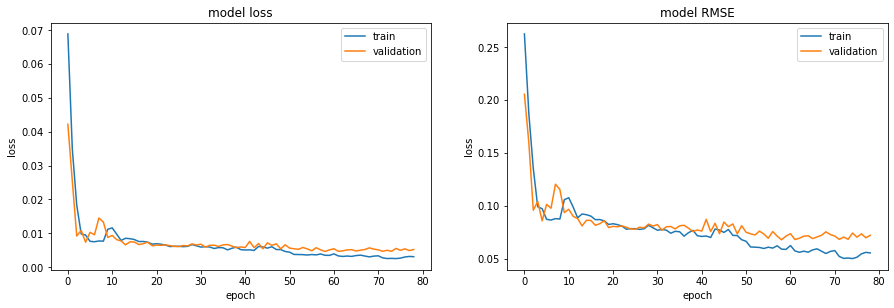

In [48]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.subplot(2, 2, 2)
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

In [49]:
# Visualization
def create_time_steps(length):
    return list(range(-length, 0))
def multi_step_plot(history, true_future, prediction, num_marker, num_marker_2 = None):
    plt.figure(figsize=(15, 10))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.subplot(2, 2, 1)
    plt.plot(np.arange(num_out), np.array(true_future[:, num_marker:num_marker+1]), 'b-',
           label='Real motion')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction[:, num_marker:num_marker+1]), 'r',
                 label='Predicted motion')
    plt.ylim(0,1)    
    plt.title(f'Marker {num_marker}')
    plt.ylabel('Displacement')
    plt.xlabel('Time [sec]')    
    plt.legend(loc='upper right')
    if num_marker_2 is not None:
        plt.subplot(2, 2, 2)
        plt.plot(np.arange(num_out), np.array(true_future[:, num_marker_2:num_marker_2+1]), 'b-',
               label='Réel mvt')
        if prediction.any():
            plt.plot(np.arange(num_out), np.array(prediction[:, num_marker_2:num_marker_2+1]), 'r',
                     label='Predicted motion')
    plt.ylim(0,1)
    plt.title(f'Marker {num_marker_2}')
    plt.ylabel('Displacement')
    plt.xlabel('Time [sec]')    
    plt.legend(loc='upper right')
    plt.show()

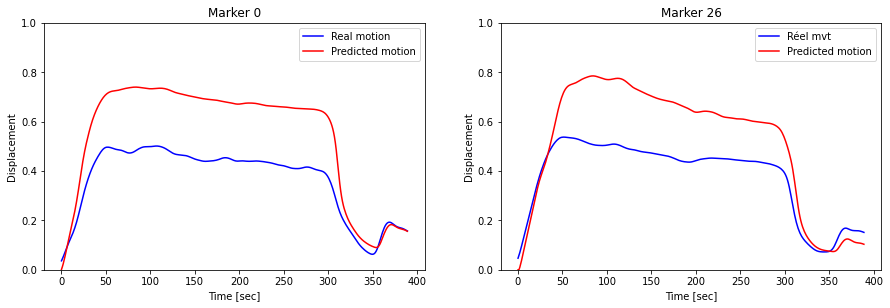

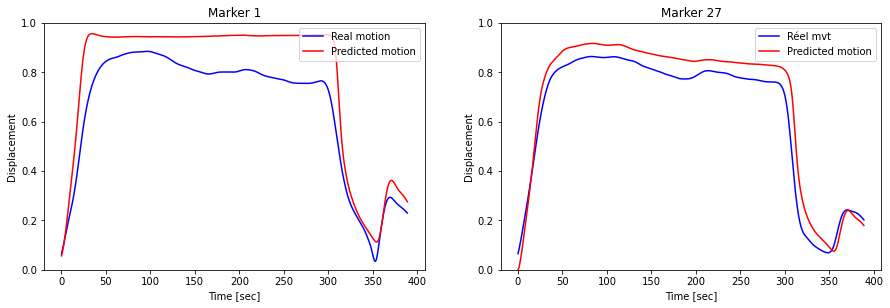

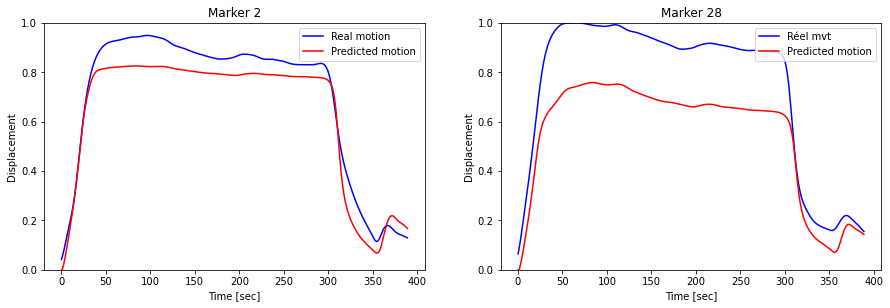

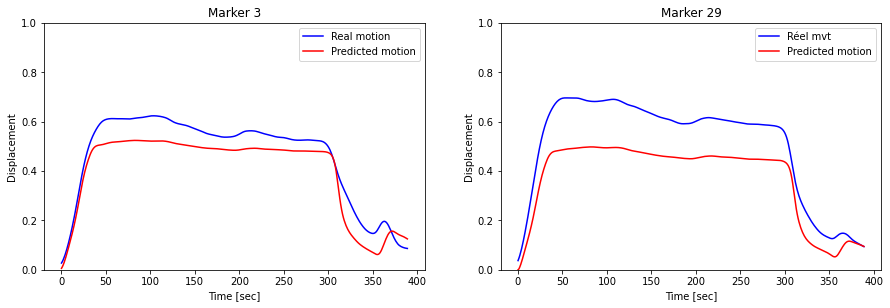

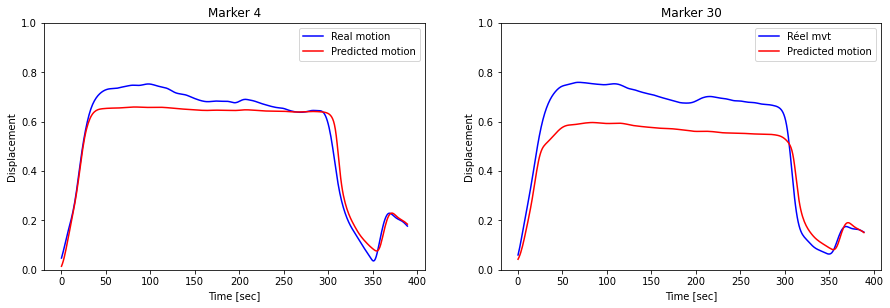

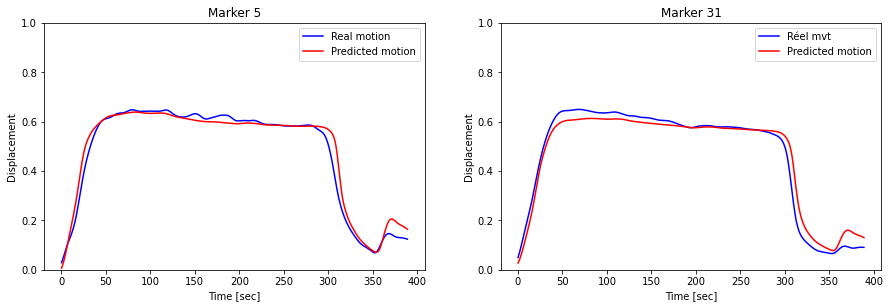

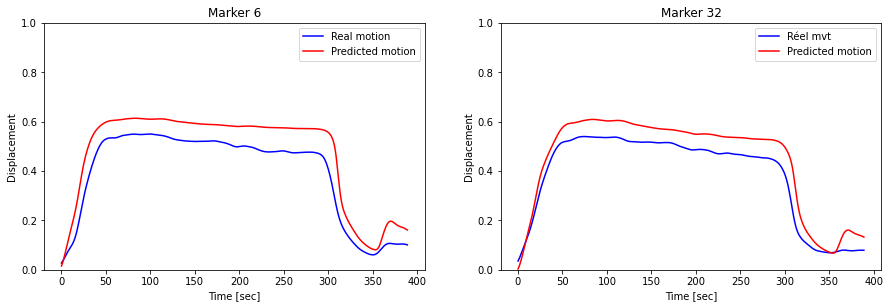

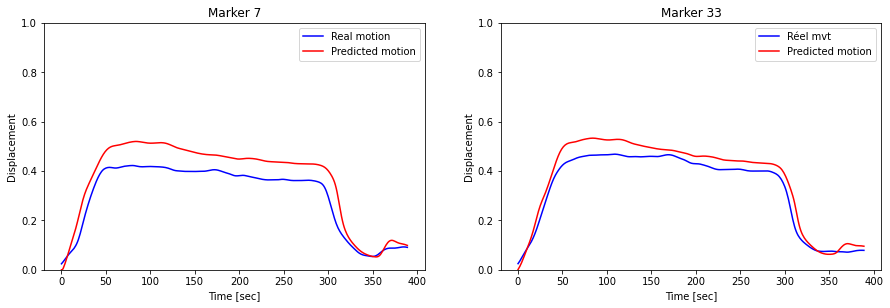

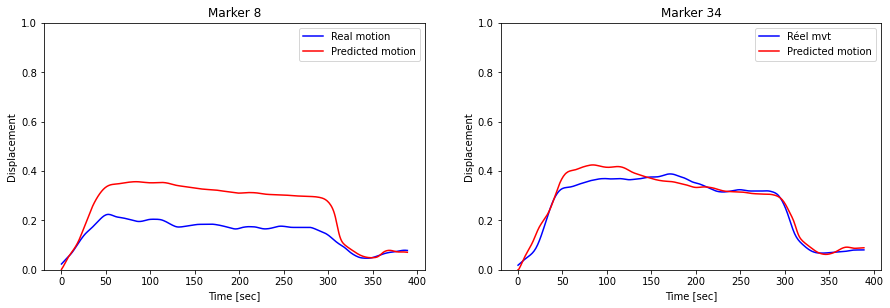

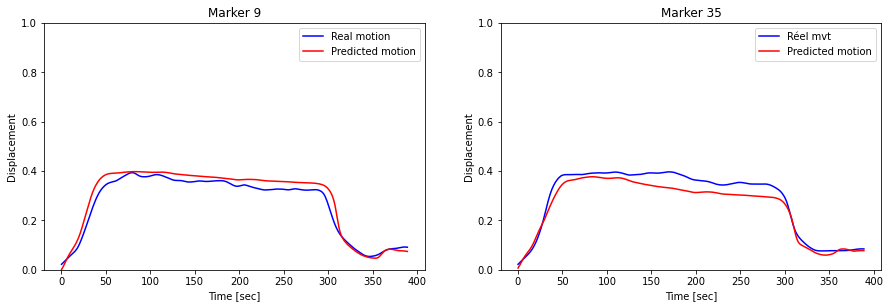

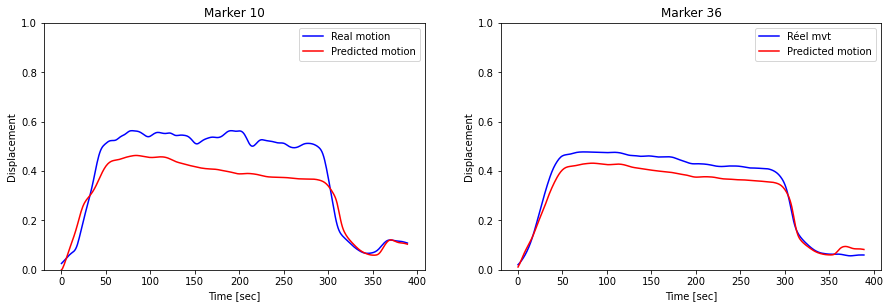

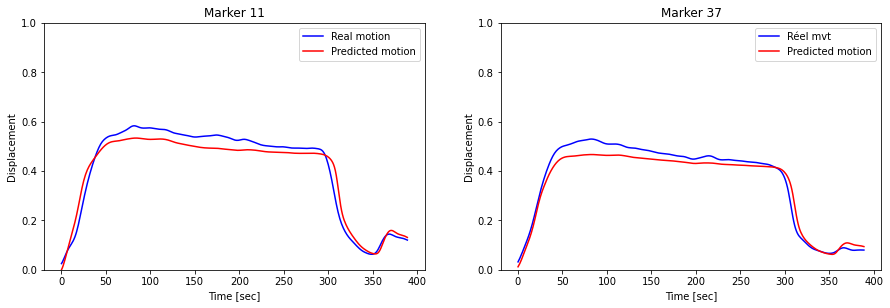

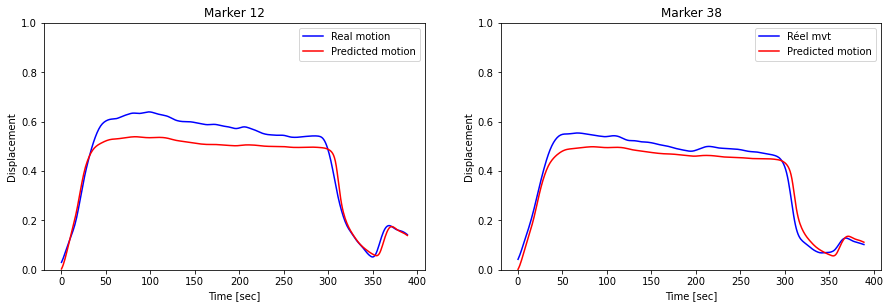

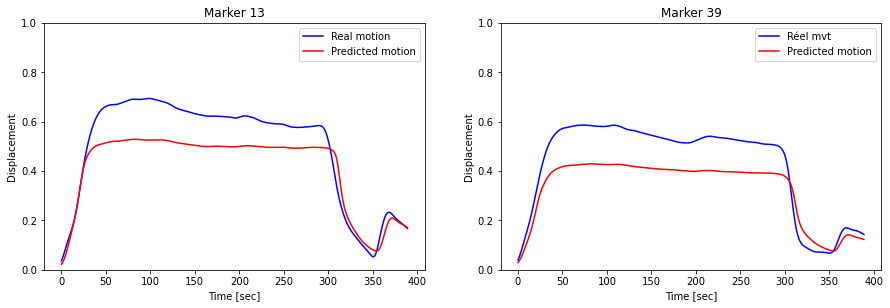

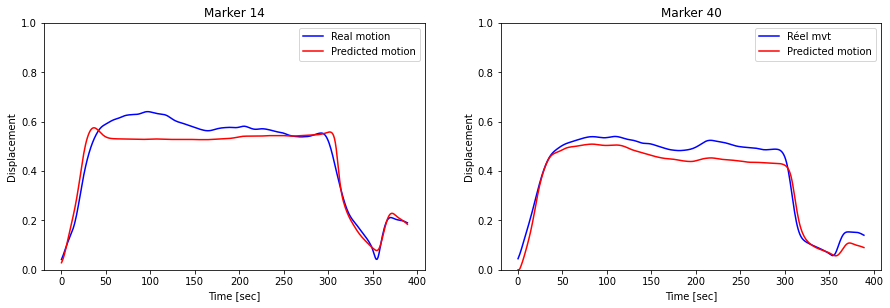

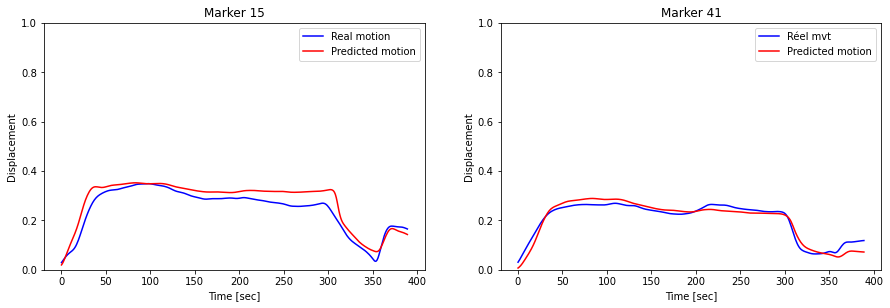

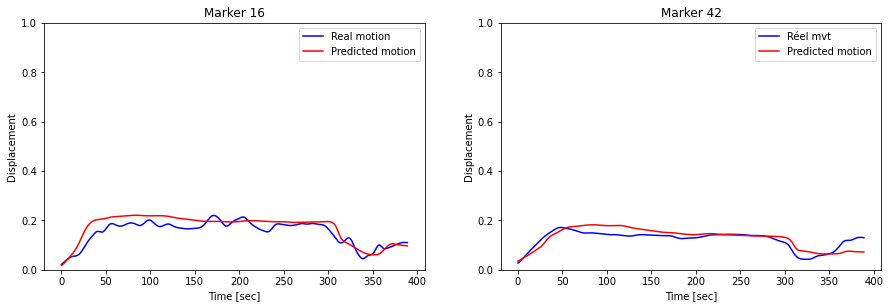

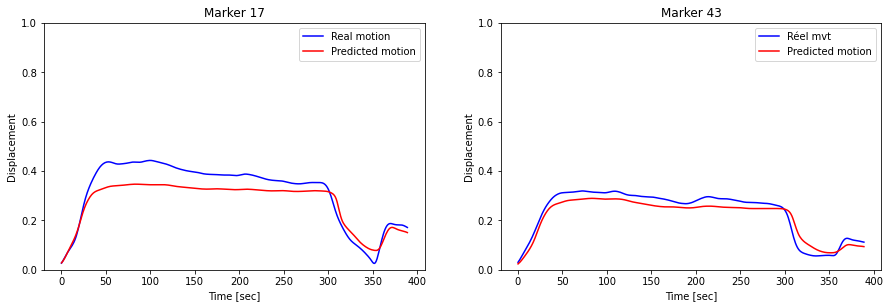

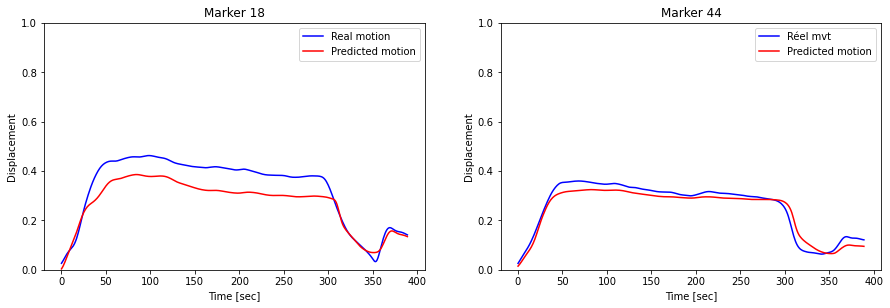

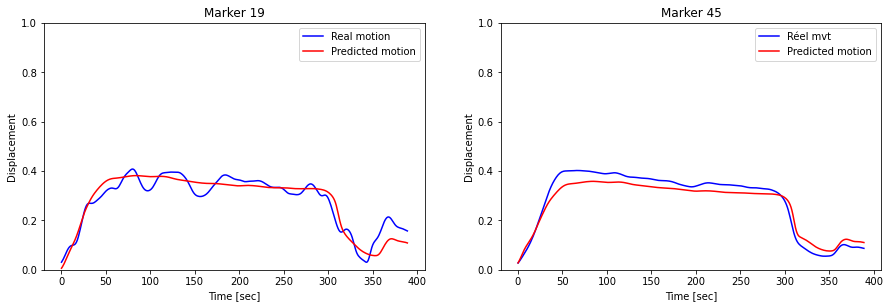

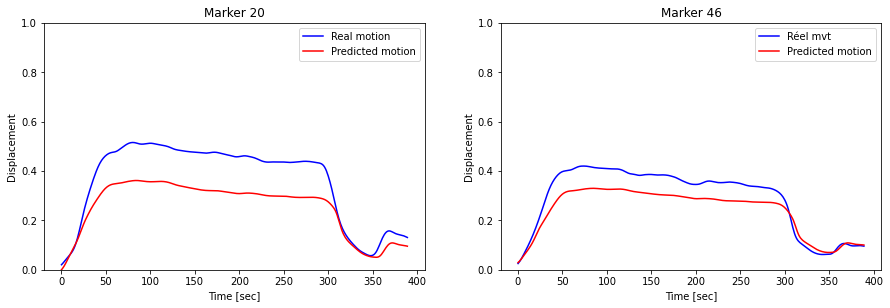

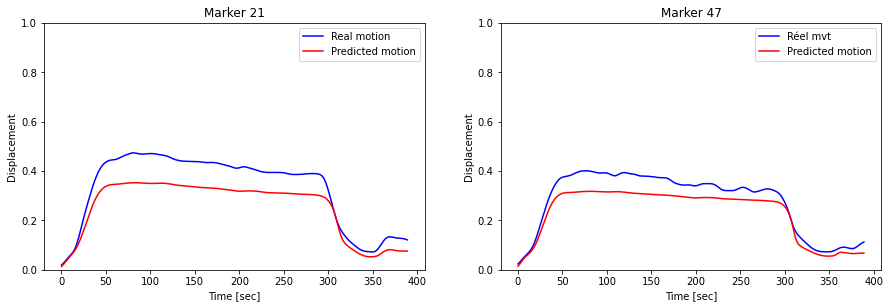

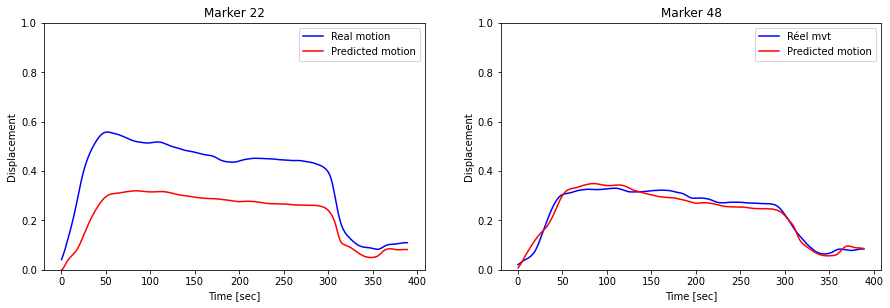

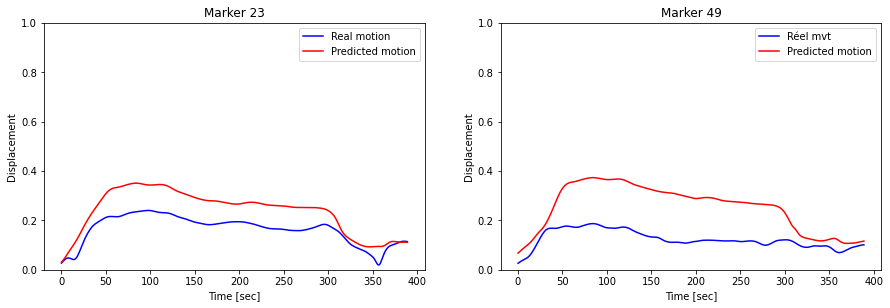

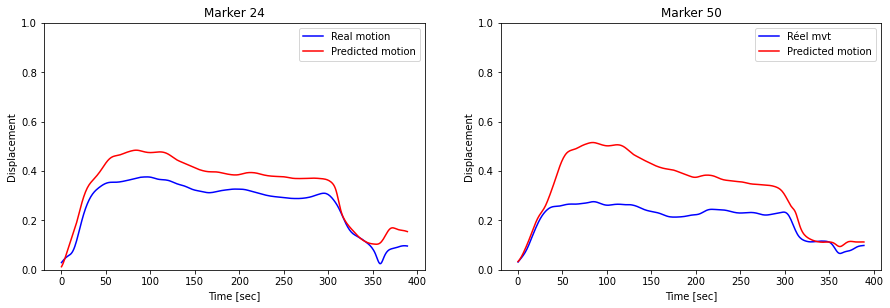

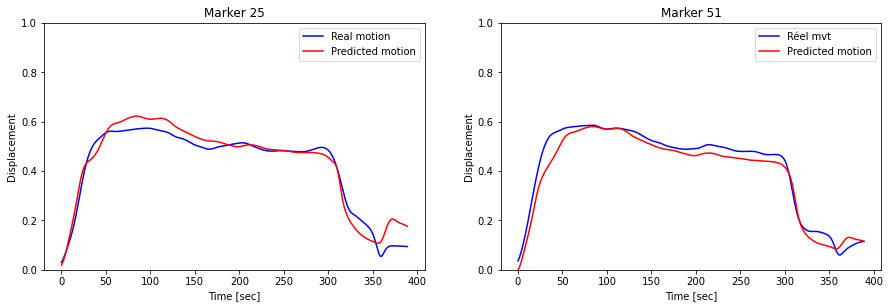

In [50]:
for x, y in dataset_test.take(1):
    for i in range(0,26):
        multi_step_plot(x[0], y,multi_lstm_model.predict(x), i,i+26)

#### RMSE

In [51]:
from sklearn.metrics import mean_squared_error
rmse_train, rmse_valid, rmse_test = list(), list(), list()

for x, y in dataset_train:
    rmse = mean_squared_error(y, multi_lstm_model.predict(x), squared=False)
    rmse_train.append(rmse)   
rmse_train = np.mean(rmse_train)

for x, y in dataset_valid:
    rmse = mean_squared_error(y, multi_lstm_model.predict(x), squared=False)
    rmse_valid.append(rmse) 
rmse_valid = np.mean(rmse_valid)

for x, y in dataset_test:
    rmse = mean_squared_error(y, multi_lstm_model.predict(x), squared=False)
    rmse_test.append(rmse) 
rmse_test = np.mean(rmse_test)

rmse_train,rmse_valid,rmse_test 

(0.04994657147677829, 0.06068846480367456, 0.06472364826726777)

In [52]:
from tensorflow.keras.models import load_model
#multi_lstm_model.save("lstm_model_6.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
#model = load_model('lstm_model.h5')
score_train = model.evaluate(dataset_train, verbose=1)
score_val = model.evaluate(dataset_valid, verbose=1)
score_test = model.evaluate(dataset_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score_train[1]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score_val[1]*100))
print("%s: %.2f%%" % (model.metrics_names[1], score_test[1]*100))

In [ ]:
model.summary()